In [3]:
%matplotlib inline


# Gaussian process regression (GPR) with noise-level estimation

This example shows the ability of the
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` to estimate the noise
level in the data. Moreover, we show the importance of kernel hyperparameters
initialization.


In [4]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <guillaume.lemaitre@inria.fr>
# License: BSD 3 clause

## Data generation

We will work in a setting where `X` will contain a single feature. We create a
function that will generate the target to be predicted. We will add an
option to add some noise to the generated target.



In [5]:
import numpy as np


def target_generator(X, add_noise=False):
    target = 0.5 + np.sin(3 * X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 0.3, size=target.shape) # 生成一个大小和target相同，均值为0，标准差为0.3的正太分布随机数组
    return target.squeeze()

Let's have a look to the target generator where we will not add any noise to
observe the signal that we would like to predict.



In [6]:
# 生成一个等间矩包含30个元素范围从0到5的一维数组（30，），利用reshape(-1,1)将一维数组转换为列向量形式（30，1）
# reshape(-1,1)-1表示numpy自动计算第一维度的维数，第二维度指定为1
X = np.linspace(0, 5, num=30).reshape(-1, 1)
y = target_generator(X, add_noise=False)

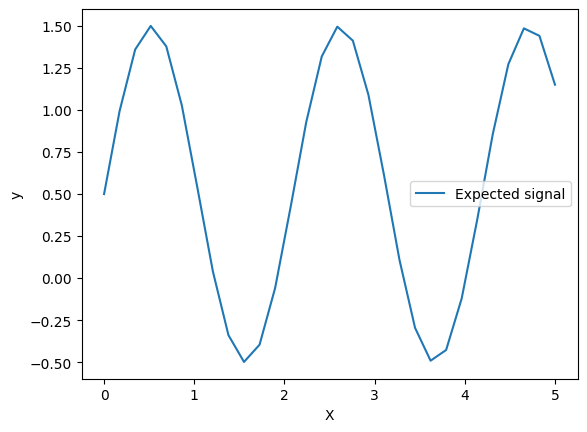

In [7]:
import matplotlib.pyplot as plt

plt.plot(X, y, label="Expected signal")
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

The target is transforming the input `X` using a sine function. Now, we will
generate few noisy training samples. To illustrate the noise level, we will
plot the true signal together with the noisy training samples.



In [8]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
y_train = target_generator(X_train, add_noise=True)

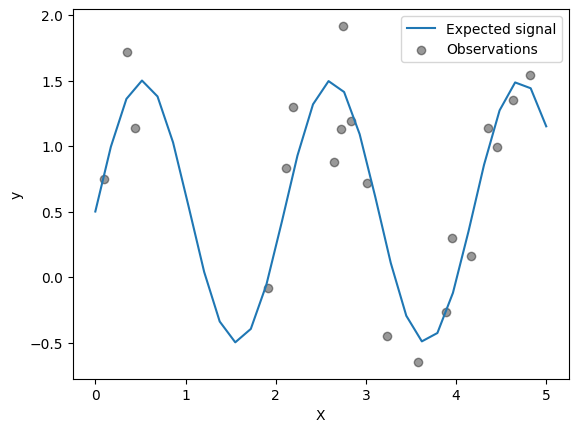

In [9]:
plt.plot(X, y, label="Expected signal")
plt.scatter(
    x=X_train[:, 0],
    y=y_train,
    color="black",
    alpha=0.4,
    label="Observations",
)
plt.legend()
plt.xlabel("X")
_ = plt.ylabel("y")

## Optimisation of kernel hyperparameters in GPR

Now, we will create a
:class:`~sklearn.gaussian_process.GaussianProcessRegressor`
using an additive kernel adding a
:class:`~sklearn.gaussian_process.kernels.RBF` and
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` kernels.
The :class:`~sklearn.gaussian_process.kernels.WhiteKernel` is a kernel that
will able to estimate the amount of noise present in the data while the
:class:`~sklearn.gaussian_process.kernels.RBF` will serve at fitting the
non-linearity between the data and the target.

However, we will show that the hyperparameter space contains several local
minima. It will highlights the importance of initial hyperparameter values.

We will create a model using a kernel with ***a high noise level and a large
length scale***, which will explain all variations in the data by noise.


<font color = blue>
a high noise level and a large //
    
这种情况下，模型会将所有样本之间的差异都归咎于噪声，而将与目标的非线性关系忽略。也就是说，模型认为所有数据变化都是由噪声引起的，而与目标的关系无关。这种情况下，模型效果很差，容易出现局部最优解，但可以用来展示对于一个具有多个局部最优解的模型，初始超参数值的重要性。
    
高噪声水平：内核在描述样本之间的相似度时，对于噪声的影响非常敏感（即：数据中存在大量的噪声）。因此模型在使用这种内核时可能会将所有数据的变化都解释为噪声，并将目标的非线性关系忽略。
    
大长度尺度：不同位置或时间点的灵气之间存在着较强的相关性或相似性，常用于处理长程依赖性的数据
<font>

<font color = green>
RBF：高斯内核函数，一种基于距离的内核函数，RBF内核函数可以将非线性问题映射到高维空间中，从而提高模型的预测能力。在高斯过程回归中，RBF内核函数被用于计算样本之间的协方差矩阵，从而生成高斯过程
    
    
WhiteKernel：一种常数内核函数，它将每个样本之间的协方差设置为一个常数（称为噪声水平），表示观测到的响应变量中的噪声
    
    
alpha噪声方差：取0表示不考虑噪声的影响，认为模型能够准确地拟合数据，alpha较小时，模型会更加灵活，也更容易受到噪声的影响，当alpha较大时，模型更加平滑，但容易欠拟合
<font>

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


kernel = 1.0 * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0) 
gpr.fit(X_train, y_train)
# X_train = rng.uniform(0, 5, size=20).reshape(-1, 1)
# y_train = target_generator(X_train, add_noise=True)
y_mean, y_std = gpr.predict(X, return_std=True)

D:\batter ai\python\python3.11.2\Lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


<font color = purple>
<strong>plt.errorbar(X, y_mean, y_std)</strong> &nbsp :绘制误差条形图，`x`是自变量的取值范围，`y_mean`是相应的因变量均值预测值，`y_std`是因变量预测值的标准差，通常将其用作误差条形图的长度或上下界

<strong>gpr.log_marginal_likelihood(gpr.kernel_.theta</strong>：对数边缘似然值，反映给定模型和数据的一致性，即模型的拟合优度和可靠性，越高越好
    
<font>

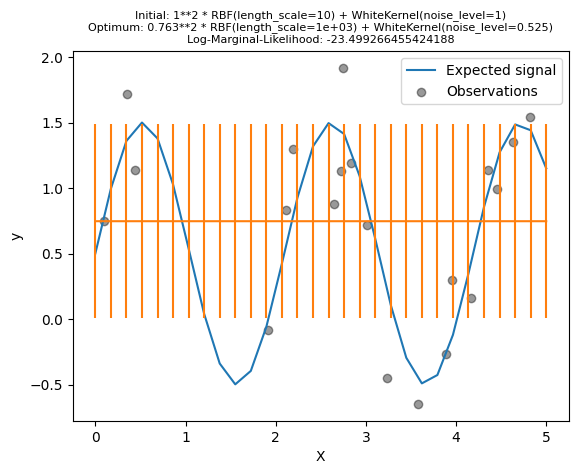

In [11]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)

We see that the optimum kernel found still have a high noise level and
an even larger length scale. Furthermore, we observe that the
model does not provide faithful predictions.

Now, we will initialize the
:class:`~sklearn.gaussian_process.kernels.RBF` with a
larger `length_scale` and the
:class:`~sklearn.gaussian_process.kernels.WhiteKernel`
with a smaller noise level lower bound.



In [12]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
gpr.fit(X_train, y_train)
y_mean, y_std = gpr.predict(X, return_std=True)

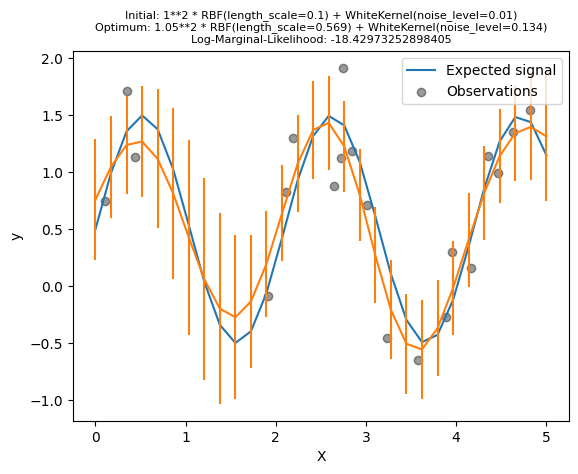

In [13]:
plt.plot(X, y, label="Expected signal")
plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(X, y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    f"Initial: {kernel}\nOptimum: {gpr.kernel_}\nLog-Marginal-Likelihood: "
    f"{gpr.log_marginal_likelihood(gpr.kernel_.theta)}",
    fontsize=8,
)

First, we see that the model's predictions are more precise than the
previous model's: this new model is able to estimate the noise-free
functional relationship.

Looking at the kernel hyperparameters, we see that the best combination found
has a smaller noise level and shorter length scale than the first model.

<font color = blue>
较小的噪声水平表示模型将输入中的噪声视为较小的影响，而更短的长度尺度则表示模型在对输入进行建模时更加平滑，即更依赖于周围点的信息，而不是在更长的距离上进行过度拟合。这可以帮助模型更好地捕捉输入中的局部变化，并对整体模式进行更好的推断,但是过小的噪声水平和过短的长度尺度可能会导致模型过拟合</font>

    
---

We can inspect the Log-Marginal-Likelihood (LML) of
:class:`~sklearn.gaussian_process.GaussianProcessRegressor`
for different hyperparameters to get a sense of the local minima.

<font color = blue>在高斯过程回归中，我们的目标是最大化似然函数，这等价于最小化负的对数边缘似然值。在训练高斯过程回归模型时，我们可以使用内核超参数进行优化，以使模型的对数边缘似然值最大化。因此，我们可以检查不同超参数下的对数边缘似然值，以了解局部最小值，并找到全局最优解。这种方法可以帮助我们了解模型在训练时的优化过程，以及优化器在搜索超参数空间时所遇到的挑战</font>


<font color = purple>
LogNorm是Matplotlib中的一个颜色映射类，将数值数据映射到颜色空间<br><br>
np.logspace(-2,4,num=50)生成指数间隔的一维数组,包含50个等间距的数字，从10的负2次方到10的4次方。<br><br>
meshgrid:可以将两个一维数组转换成两个二维矩阵，枚举两个一维数组之间的组合
</font>

In [14]:
from matplotlib.colors import LogNorm

length_scale = np.logspace(-2, 4, num=50)
noise_level = np.logspace(-2, 1, num=50)
length_scale_grid, noise_level_grid = np.meshgrid(length_scale, noise_level)

log_marginal_likelihood = [
    gpr.log_marginal_likelihood(theta=np.log([0.36, scale, noise]))
    for scale, noise in zip(length_scale_grid.ravel(), noise_level_grid.ravel())
]
log_marginal_likelihood = np.reshape(
    log_marginal_likelihood, newshape=noise_level_grid.shape
)

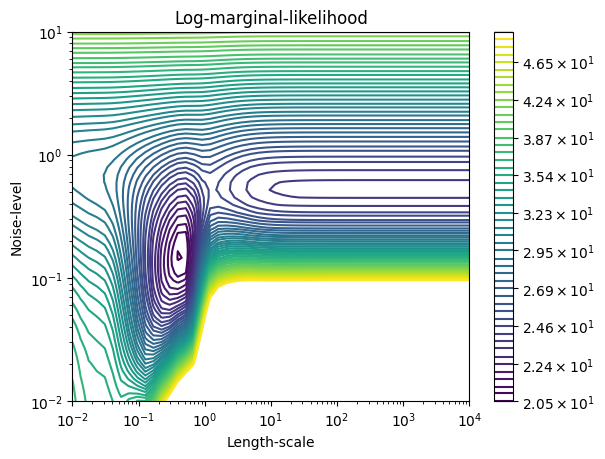

In [18]:
vmin, vmax = (-log_marginal_likelihood).min(), 50 # 设置色图范围
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), num=50), decimals=1)
plt.contour(
    length_scale_grid, # 绘制等高线的x轴数据
    noise_level_grid, # 绘制等高线的y轴数据
    -log_marginal_likelihood, # 等高线的高度，
    levels=level, # 等高线的数量
    norm=LogNorm(vmin=vmin, vmax=vmax), # 绘制等高线的归一化方式
)
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.show()

We see that there are two local minima that correspond to the combination
of hyperparameters previously found. Depending on the initial values for the
hyperparameters, the gradient-based optimization might converge whether or
not to the best model. It is thus important to repeat the optimization
several times for different initializations.

